In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

from scipy.stats import ks_2samp

### MATH 189 Final Project

# to find if there exists a referee bias in decision-making towards the home team in football (soccer) in the Premier League

## var = virtual assistant referee

#### Import the Data

In [2]:
pl_2017 = pd.read_csv('data/PL_2017_2018.csv')
pl_2018 = pd.read_csv('data/PL_2018_2019.csv')
pl_2019 = pd.read_csv('data/PL_2019_2020.csv')
pl_2022 = pd.read_csv('data/PL_2022_2023.csv')
pl_2023 = pd.read_csv('data/PL_2023_2024.csv')

# Exploratory Data Analysis

## first, we look at the columns in the df's and:
- remove the unnecessary ones
- rename the relevant columns that we've selected

In [3]:
pl_2017.head(5)

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
0,E0,11/08/2017,Arsenal,Leicester,4,3,H,2,2,D,...,2.32,21,-1.00,1.91,1.85,2.10,2.02,1.49,4.73,7.25
1,E0,12/08/2017,Brighton,Man City,0,2,A,0,0,D,...,2.27,20,1.50,1.95,1.91,2.01,1.96,11.75,6.15,1.29
2,E0,12/08/2017,Chelsea,Burnley,2,3,A,0,3,A,...,2.23,20,-1.75,2.03,1.97,1.95,1.90,1.33,5.40,12.25
3,E0,12/08/2017,Crystal Palace,Huddersfield,0,3,A,0,2,A,...,1.72,18,-0.75,2.10,2.05,1.86,1.83,1.79,3.56,5.51
4,E0,12/08/2017,Everton,Stoke,1,0,H,1,0,H,...,1.76,19,-0.75,1.94,1.90,2.01,1.98,1.82,3.49,5.42


In [4]:
pl_2023.head(5)

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,E0,11/08/2023,20:00,Burnley,Man City,0,3,A,0,2,...,2.28,1.50,1.95,1.98,1.95,1.97,NaN,NaN,1.92,1.95
1,E0,12/08/2023,12:30,Arsenal,Nott'm Forest,2,1,H,2,0,...,2.63,-2.00,1.95,1.98,1.93,1.97,2.01,2.09,1.95,1.92
2,E0,12/08/2023,15:00,Bournemouth,West Ham,1,1,D,0,0,...,2.12,0.00,2.02,1.91,2.01,1.92,2.06,1.96,1.96,1.91
3,E0,12/08/2023,15:00,Brighton,Luton,4,1,H,1,0,...,2.48,-1.75,2.01,1.92,2.00,1.91,2.14,1.93,2.00,1.86
4,E0,12/08/2023,15:00,Everton,Fulham,0,1,A,0,0,...,1.71,-0.25,2.06,1.87,2.04,1.88,2.08,1.99,1.98,1.88


In [5]:
# the columns related to betting data - look at notes.txt for more info
columns_to_keep = [
    'Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam',
    'FTHG', 'HG', 'FTAG', 'AG', 'FTR', 'Res',
    'HTHG', 'HTAG', 'HTR',
    'Attendance', 'Referee',
    'HS', 'AS', 'HST', 'AST', 'HHW', 'AHW',
    'HC', 'AC', 'HF', 'AF', 'HFKC', 'AFKC',
    'HO', 'AO', 'HY', 'AY', 'HR', 'AR',
    'HBP', 'ABP'
]

pl_2017 = pl_2017[[col for col in columns_to_keep if col in pl_2017.columns]]
pl_2018 = pl_2018[[col for col in columns_to_keep if col in pl_2018.columns]]
pl_2019 = pl_2019[[col for col in columns_to_keep if col in pl_2019.columns]]
pl_2022 = pl_2022[[col for col in columns_to_keep if col in pl_2022.columns]]
pl_2023 = pl_2023[[col for col in columns_to_keep if col in pl_2023.columns]]

rename_columns = {
    'Div': 'LeagueDivision',
    'Date': 'MatchDate',
    'Time': 'KickoffTime',
    'HomeTeam': 'HomeTeam',
    'AwayTeam': 'AwayTeam',
    'FTHG': 'FullTimeHomeGoals',
    'FTAG': 'FullTimeAwayGoals',
    'FTR': 'FullTimeResult',
    'HTHG': 'HalfTimeHomeGoals',
    'HTAG': 'HalfTimeAwayGoals',
    'HTR': 'HalfTimeResult',
    'Attendance': 'Attendance',
    'Referee': 'Referee',
    'HS': 'HomeShots',
    'AS': 'AwayShots',
    'HST': 'HomeShotsOnTarget',
    'AST': 'AwayShotsOnTarget',
    'HHW': 'HomeHitWoodwork',
    'AHW': 'AwayHitWoodwork',
    'HC': 'HomeCorners',
    'AC': 'AwayCorners',
    'HF': 'HomeFouls',
    'AF': 'AwayFouls',
    'HFKC': 'HomeFreeKicksConceded',
    'AFKC': 'AwayFreeKicksConceded',
    'HO': 'HomeOffsides',
    'AO': 'AwayOffsides',
    'HY': 'HomeYellowCards',
    'AY': 'AwayYellowCards',
    'HR': 'HomeRedCards',
    'AR': 'AwayRedCards',
    'HBP': 'HomeBookingPoints',
    'ABP': 'AwayBookingPoints'
}

pl_2017.rename(columns=rename_columns, inplace=True)
pl_2018.rename(columns=rename_columns, inplace=True)
pl_2019.rename(columns=rename_columns, inplace=True)
pl_2022.rename(columns=rename_columns, inplace=True)
pl_2023.rename(columns=rename_columns, inplace=True)

## next, we find and deal with any missing/null values

In [6]:
print(f'Null values in pl_2017 dataset: {pl_2017.isna().sum().sum()}')
print(f'Null values in pl_2018 dataset: {pl_2018.isna().sum().sum()}')
print(f'Null values in pl_2019 dataset: {pl_2019.isna().sum().sum()}')
print(f'Null values in pl_2022 dataset: {pl_2022.isna().sum().sum()}')
print(f'Null values in pl_2023 dataset: {pl_2023.isna().sum().sum()}')

Null values in pl_2017 dataset: 0
Null values in pl_2018 dataset: 0
Null values in pl_2019 dataset: 0
Null values in pl_2022 dataset: 0
Null values in pl_2023 dataset: 0


## third, we converted the variables that were meant to be categorical into categorical variables in the dataframe

In [7]:
pl_2017.columns

Index(['LeagueDivision', 'MatchDate', 'HomeTeam', 'AwayTeam',
       'FullTimeHomeGoals', 'FullTimeAwayGoals', 'FullTimeResult',
       'HalfTimeHomeGoals', 'HalfTimeAwayGoals', 'HalfTimeResult', 'Referee',
       'HomeShots', 'AwayShots', 'HomeShotsOnTarget', 'AwayShotsOnTarget',
       'HomeCorners', 'AwayCorners', 'HomeFouls', 'AwayFouls',
       'HomeYellowCards', 'AwayYellowCards', 'HomeRedCards', 'AwayRedCards'],
      dtype='object')

In [8]:
categorical_cols = [
    'LeagueDivision',
    'MatchDate'
    'HomeTeam',
    'AwayTeam',
    'FullTimeResult',
    'HalfTimeResult',
    'Referee'
]

for col in categorical_cols:
    if col in pl_2017.columns:
        pl_2017[col] = pl_2017[col].astype('category')
    if col in pl_2018.columns:
        pl_2018[col] = pl_2018[col].astype('category')
    if col in pl_2019.columns:
        pl_2019[col] = pl_2019[col].astype('category')
    if col in pl_2022.columns:
        pl_2022[col] = pl_2022[col].astype('category')
    if col in pl_2023.columns:
        pl_2023[col] = pl_2023[col].astype('category')

Dataset Description

In [9]:
pl_2023.describe()

,FullTimeHomeGoals,FullTimeAwayGoals,HalfTimeHomeGoals,HalfTimeAwayGoals,HomeShots,AwayShots,HomeShotsOnTarget,AwayShotsOnTarget,HomeCorners,AwayCorners,HomeFouls,AwayFouls,HomeYellowCards,AwayYellowCards,HomeRedCards,AwayRedCards
count,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000
mean,1.800000,1.478947,0.734211,0.626316,15.402632,12.181579,5.436842,4.431579,6.123684,4.713158,10.744737,11.347368,1.910526,2.263158,0.068421,0.081579
std,1.365616,1.277811,0.831687,0.823367,6.261959,5.467696,2.885449,2.526493,3.221460,2.906518,3.457331,3.674826,1.392553,1.389448,0.263030,0.283546
min,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,11.000000,8.000000,3.000000,3.000000,4.000000,3.000000,8.000000,9.000000,1.000000,1.000000,0.000000,0.000000
50%,2.000000,1.000000,1.000000,0.000000,15.000000,11.000000,5.000000,4.000000,6.000000,4.000000,11.000000,11.000000,2.000000,2.000000,0.000000,0.000000
75%,3.000000,2.000000,1.000000,1.000000,19.000000,15.000000,7.000000,6.000000,8.000000,6.000000,13.000000,14.000000,3.000000,3.000000,0.000000,0.000000
max,6.000000,8.000000,4.000000,5.000000,36.000000,30.000000,15.000000,15.000000,17.000000,15.000000,20.000000,22.000000,6.000000,7.000000,2.000000,2.000000


## fourth, we look at the aggregate results across the 5 years

<Figure size 1200x600 with 0 Axes>

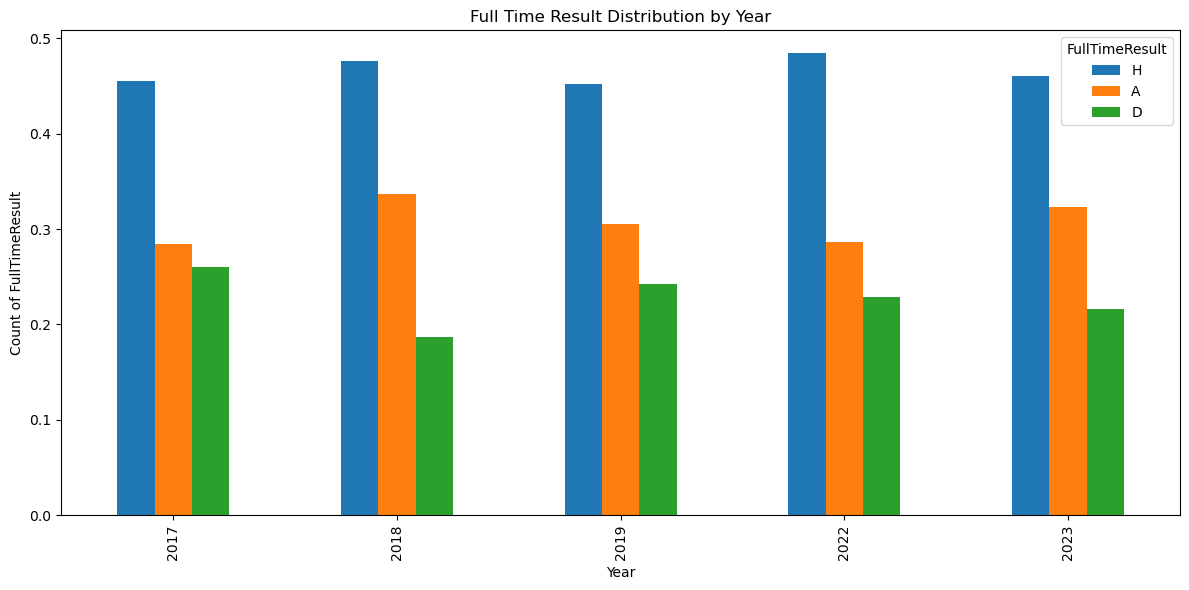

In [10]:
ftr_counts_2017 = pl_2017["FullTimeResult"].value_counts()/len(pl_2017)
ftr_counts_2018 = pl_2018["FullTimeResult"].value_counts()/len(pl_2018)
ftr_counts_2019 = pl_2019["FullTimeResult"].value_counts()/len(pl_2019)
ftr_counts_2022 = pl_2022["FullTimeResult"].value_counts()/len(pl_2022)
ftr_counts_2023 = pl_2023["FullTimeResult"].value_counts()/len(pl_2023)

ftr_count_df = pd.DataFrame({
    '2017': ftr_counts_2017,
    '2018': ftr_counts_2018,
    '2019': ftr_counts_2019,
    '2022': ftr_counts_2022,
    '2023': ftr_counts_2023
}).T

plt.figure(figsize=(12,6))
ftr_count_df.plot(kind='bar', figsize=(12,6)) 

plt.title("Full Time Result Distribution by Year")
plt.xlabel("Year")
plt.ylabel("Count of FullTimeResult")
plt.legend(title="FullTimeResult")
plt.tight_layout()
plt.show()

#### what's evident here is that the home team tends to win more often. obviously, this is a result of Goal Difference. we aim to investigate whether this is due to bias (i.e. the referee systematically preferring the home team through conflictual calling) or pure skill

## combining df's into one massive df

In [11]:
pl_2017['Season'] = '2017'
pl_2018['Season'] = '2018'
pl_2019['Season'] = '2019'
pl_2022['Season'] = '2022'
pl_2023['Season'] = '2023'

combined_df = pd.concat([pl_2017, pl_2018, pl_2019, pl_2022, pl_2023])

In [12]:
combined_df.columns

Index(['LeagueDivision', 'MatchDate', 'HomeTeam', 'AwayTeam',
       'FullTimeHomeGoals', 'FullTimeAwayGoals', 'FullTimeResult',
       'HalfTimeHomeGoals', 'HalfTimeAwayGoals', 'HalfTimeResult', 'Referee',
       'HomeShots', 'AwayShots', 'HomeShotsOnTarget', 'AwayShotsOnTarget',
       'HomeCorners', 'AwayCorners', 'HomeFouls', 'AwayFouls',
       'HomeYellowCards', 'AwayYellowCards', 'HomeRedCards', 'AwayRedCards',
       'Season', 'KickoffTime'],
      dtype='object')

In [13]:
combined_df = combined_df.drop(columns={"LeagueDivision"})
combined_df.columns

Index(['MatchDate', 'HomeTeam', 'AwayTeam', 'FullTimeHomeGoals',
       'FullTimeAwayGoals', 'FullTimeResult', 'HalfTimeHomeGoals',
       'HalfTimeAwayGoals', 'HalfTimeResult', 'Referee', 'HomeShots',
       'AwayShots', 'HomeShotsOnTarget', 'AwayShotsOnTarget', 'HomeCorners',
       'AwayCorners', 'HomeFouls', 'AwayFouls', 'HomeYellowCards',
       'AwayYellowCards', 'HomeRedCards', 'AwayRedCards', 'Season',
       'KickoffTime'],
      dtype='object')

## distribution of fouls

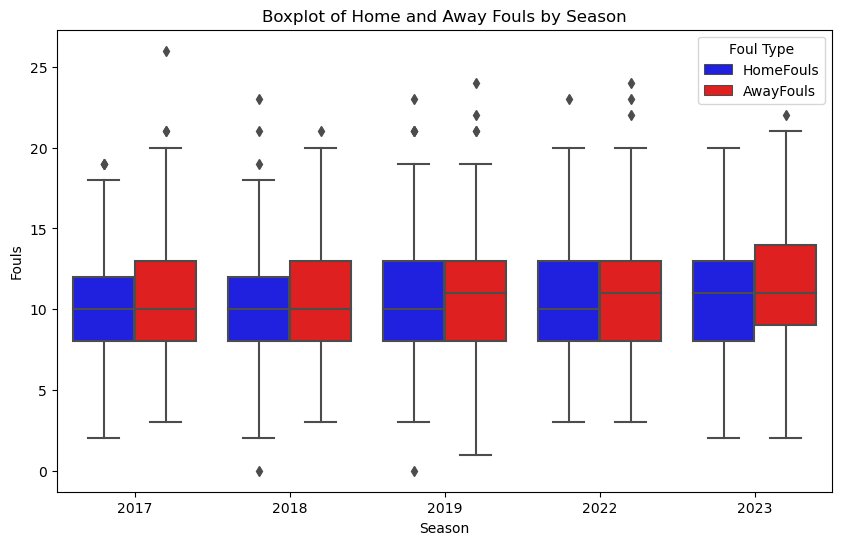

In [14]:
fouls_df = combined_df[['Season', 'HomeFouls', 'AwayFouls']]

fouls_df = fouls_df.melt(id_vars='Season', 
                    value_vars=['HomeFouls', 'AwayFouls'],
                    var_name='FoulType', 
                    value_name='Fouls')

# Create a single boxplot with hue separating Home vs Away
plt.figure(figsize=(10, 6))
sns.boxplot(x='Season', y='Fouls', hue='FoulType', data=fouls_df, palette=['blue', 'red'])

plt.title('Boxplot of Home and Away Fouls by Season')
plt.xlabel('Season')
plt.ylabel('Fouls')
plt.legend(title='Foul Type', loc='best')
plt.show()

## distribution of yellow cards, red cards

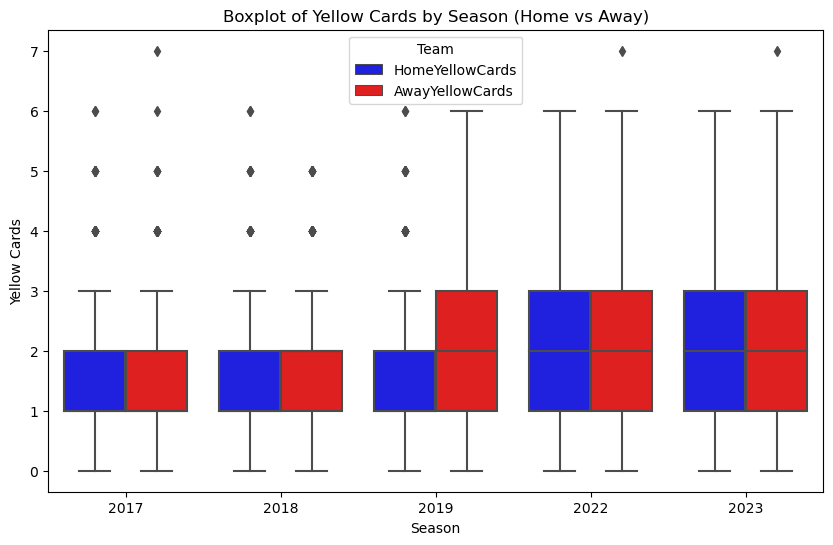

In [15]:
yellow_cards_df = combined_df.melt(
    id_vars=['Season'],
    value_vars=['HomeYellowCards', 'AwayYellowCards'],
    var_name='TeamType',
    value_name='YellowCards'
)

plt.figure(figsize=(10, 6))

sns.boxplot(
    x='Season',
    y='YellowCards',
    hue='TeamType',
    data=yellow_cards_df,
    palette={'HomeYellowCards': 'blue', 'AwayYellowCards': 'red'}
)

plt.title('Boxplot of Yellow Cards by Season (Home vs Away)')
plt.xlabel('Season')
plt.ylabel('Yellow Cards')
plt.legend(title='Team')
plt.show()

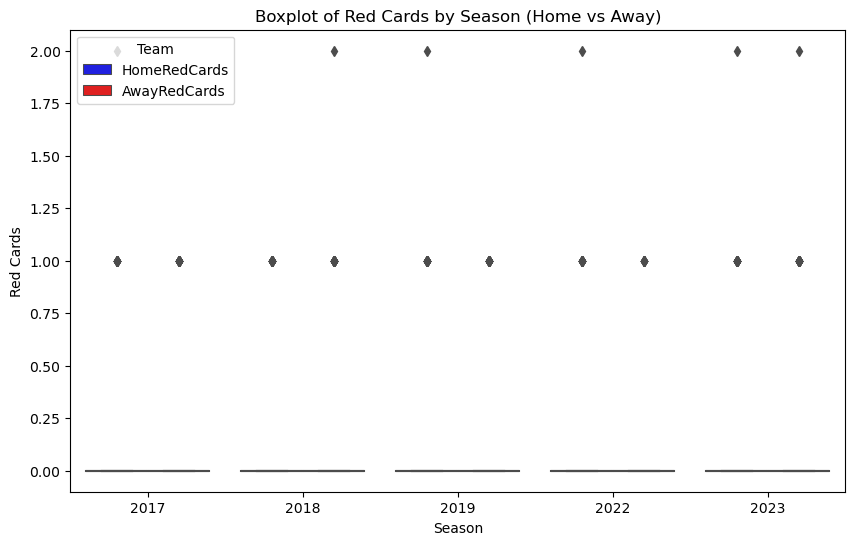

In [16]:
red_cards_df = combined_df.melt(
    id_vars=['Season'],
    value_vars=['HomeRedCards', 'AwayRedCards'],
    var_name='TeamType',
    value_name='RedCards'
)

plt.figure(figsize=(10, 6))

sns.boxplot(
    x='Season',
    y='RedCards',
    hue='TeamType',
    data=red_cards_df,
    palette={'HomeRedCards': 'blue', 'AwayRedCards': 'red'}
)

plt.title('Boxplot of Red Cards by Season (Home vs Away)')
plt.xlabel('Season')
plt.ylabel('Red Cards')
plt.legend(title='Team')
plt.show()

#### red cards are not often awarded; this makes perfect sense

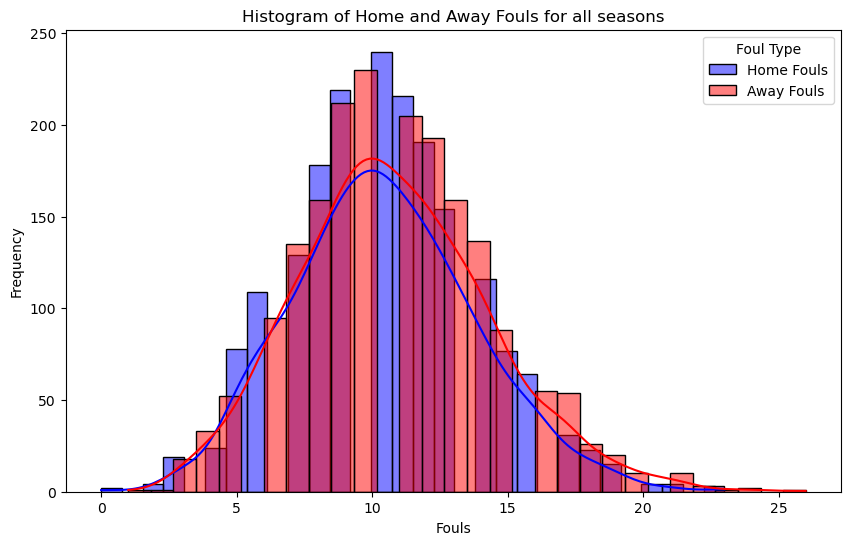

In [35]:
#### Histograms of Home and Away Fouls combined for all seasons
plt.figure(figsize=(10, 6))
sns.histplot(combined_df['HomeFouls'], color='blue', kde=True, label='Home Fouls', bins=30)
sns.histplot(combined_df['AwayFouls'], color='red', kde=True, label='Away Fouls', bins=30)

plt.title('Histogram of Home and Away Fouls for all seasons')
plt.xlabel('Fouls')
plt.ylabel('Frequency')
plt.legend(title='Foul Type')
plt.show()

## correlation matrix of JUST the numerical columns

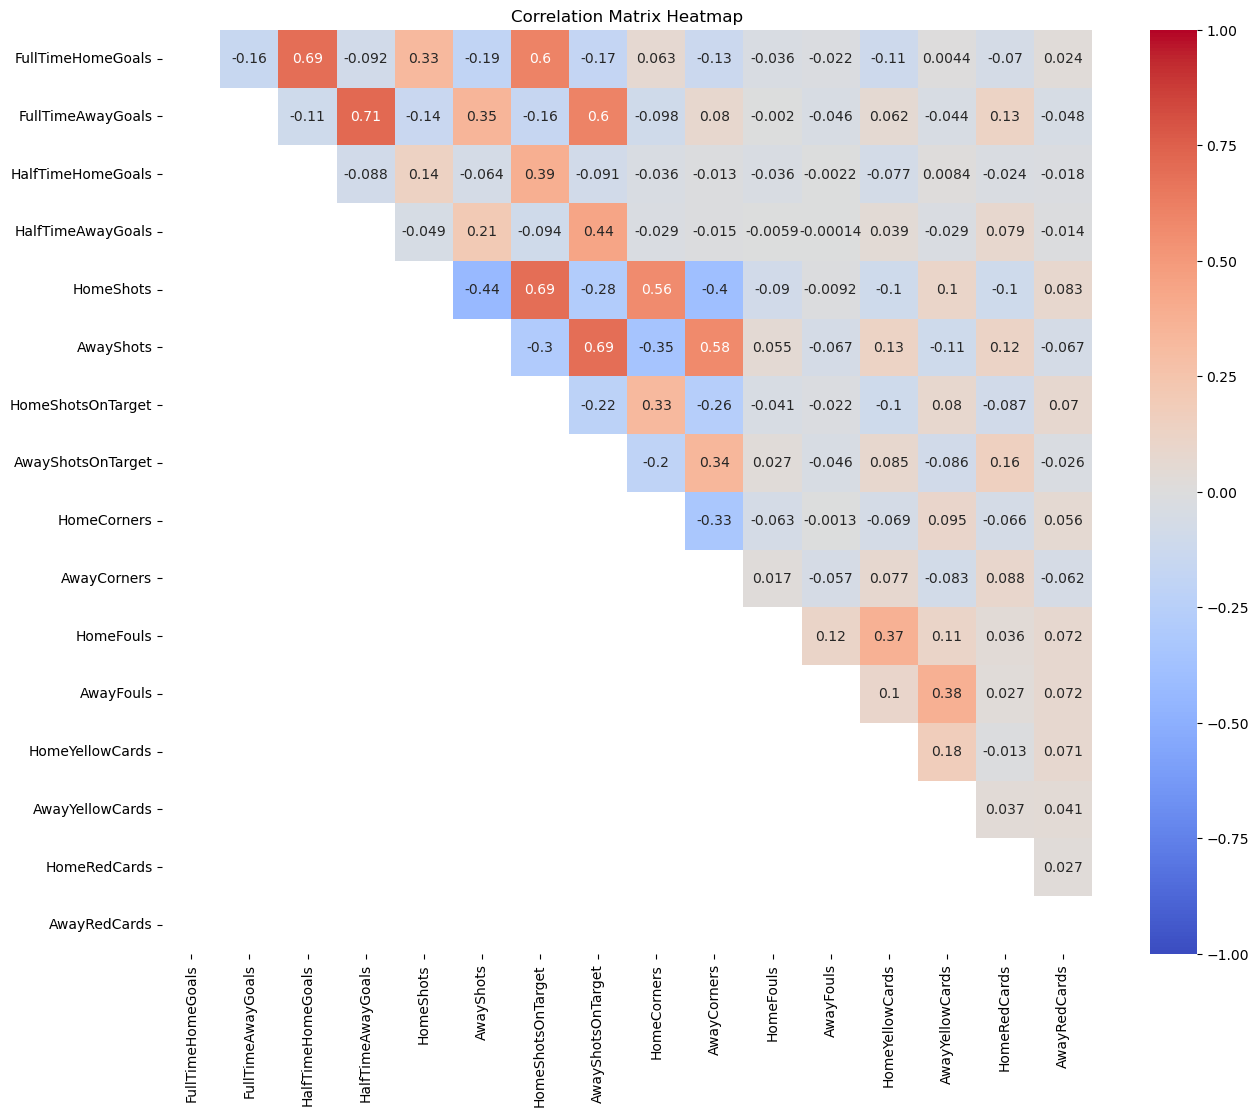

In [18]:
#make mathcdate = is_weekend ; not_is_weekend
#make referee = ???

df_numerical = combined_df.drop(columns={"MatchDate", "Referee", 'KickoffTime','HomeTeam', 'AwayTeam', 'FullTimeResult', 'HalfTimeResult', 'Season'})
corr = df_numerical.corr()
mask = np.tril(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(15, 12))

# Create a heatmap with annotations and a diverging color palette
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Add a title (optional)
plt.title('Correlation Matrix Heatmap')

# Display the plot
plt.show()

## correlation matrix with relevant categorical variables

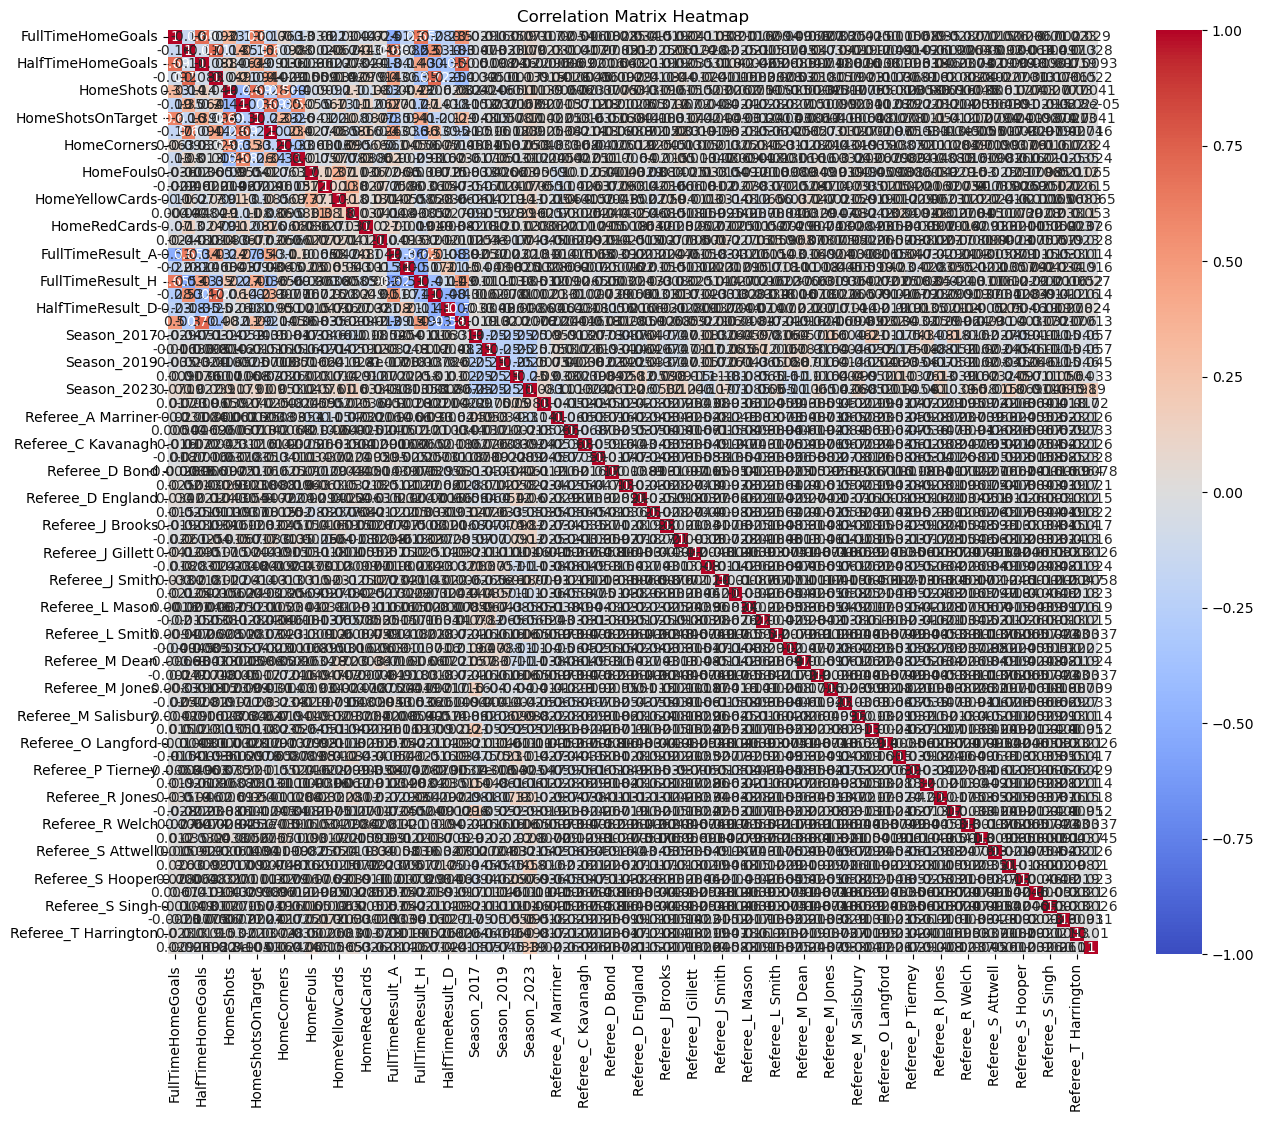

In [19]:
df_categorical = pd.get_dummies(combined_df, columns=['FullTimeResult', 'HalfTimeResult', 'Season', "Referee"], drop_first=False)
df_categorical = df_categorical.drop(columns={"MatchDate", 'KickoffTime','HomeTeam', 'AwayTeam'})

corr = df_categorical.corr()

plt.figure(figsize=(15, 12))

# Create a heatmap with annotations and a diverging color palette
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Add a title (optional)
plt.title('Correlation Matrix Heatmap')

# Display the plot
plt.show()

In [20]:
#time vs fouls - aniket
#is_weekend / not_is_weekend vs fouls - aniket
#home_team_result vs. home_team_corners - varun
#home_team_result vs away_team_fouls - varun
#home_team_win - varun

#PCA to find the key features - find the most relevant feature - varun
#the features that support the home team - are those differences/observed values significant
#do before-after VAR stuff

#pick an appropriate feature and make a test statistic - either just linear regression/PCR/log regression

## investigating if a different kickoff time affects anything

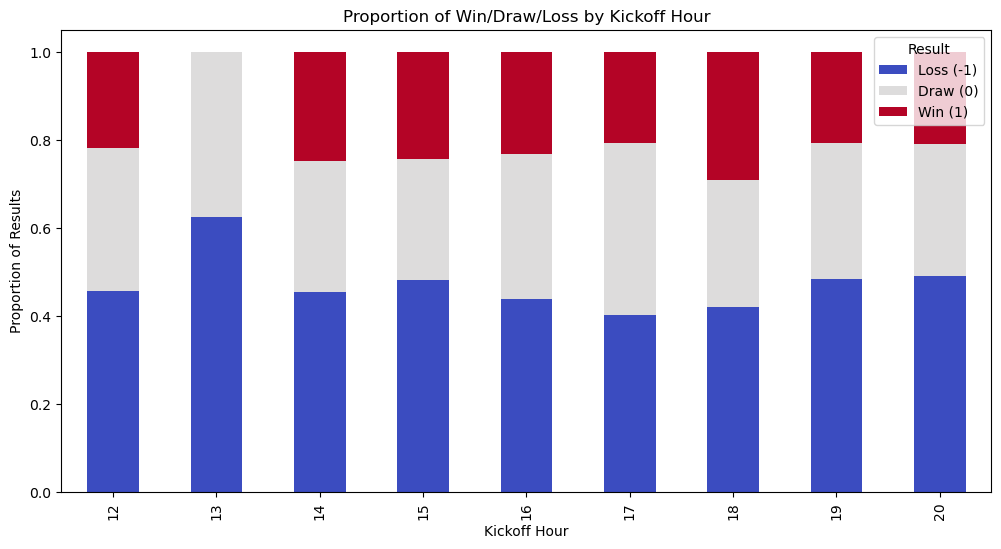

In [21]:
time_win = combined_df[['KickoffTime', 'FullTimeResult', 'HomeFouls', 'AwayFouls', 'HomeYellowCards', 'AwayYellowCards']]
time_win = time_win.dropna()
# Group by hour and calculate outcome percentages
time_win['KickoffHour'] = pd.to_datetime(time_win['KickoffTime']).dt.hour
hourly_results = time_win.groupby('KickoffHour')['FullTimeResult'].value_counts(normalize=True).unstack().fillna(0)

# Plot
hourly_results.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='coolwarm')
plt.xlabel('Kickoff Hour')
plt.ylabel('Proportion of Results')
plt.title('Proportion of Win/Draw/Loss by Kickoff Hour')
plt.legend(title='Result', labels=['Loss (-1)', 'Draw (0)', 'Win (1)'])
plt.show()

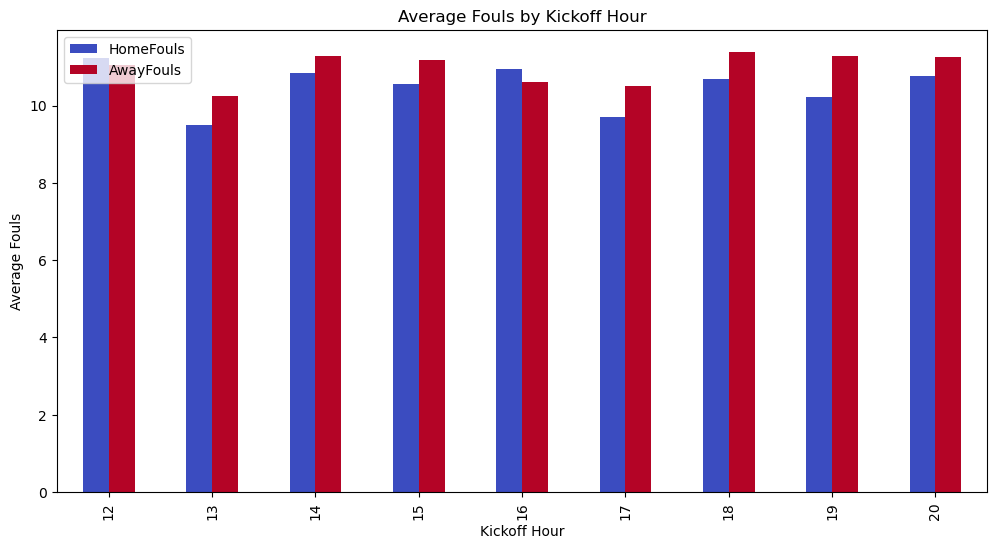

In [22]:
# plot the fouls by hour
hourly_fouls = time_win.groupby('KickoffHour')[['HomeFouls', 'AwayFouls']].mean()
hourly_fouls.plot(kind='bar', figsize=(12, 6), colormap='coolwarm')
plt.xlabel('Kickoff Hour')
plt.ylabel('Average Fouls')
plt.title('Average Fouls by Kickoff Hour')
plt.show()

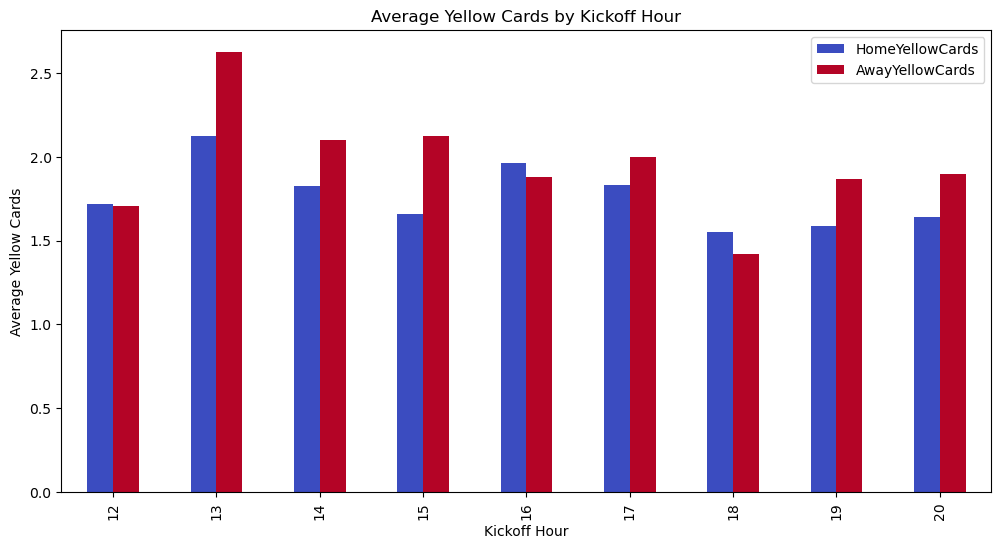

In [23]:
# plot the yellow cards by hour
hourly_yellow_cards = time_win.groupby('KickoffHour')[['HomeYellowCards', 'AwayYellowCards']].mean()
hourly_yellow_cards.plot(kind='bar', figsize=(12, 6), colormap='coolwarm')
plt.xlabel('Kickoff Hour')
plt.ylabel('Average Yellow Cards')
plt.title('Average Yellow Cards by Kickoff Hour')
plt.show()

## investigating if having a game on the weekend affects anything

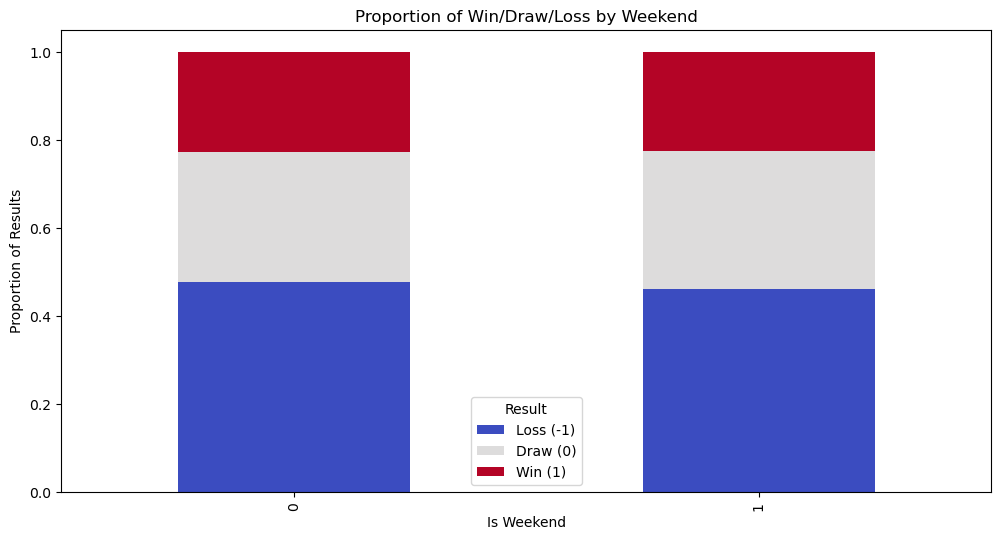

In [24]:
weekend_win = combined_df[['MatchDate', 'FullTimeResult', 'HomeFouls', 'AwayFouls', 'HomeYellowCards', 'AwayYellowCards']]
weekend_win = weekend_win.dropna()
# Group by is weekend and calculate outcome percentages
weekend_win['IsWeekend'] = pd.to_datetime(weekend_win['MatchDate'], format="%d/%m/%Y").dt.dayofweek.isin([5, 6]).astype(int)

weekend_results = weekend_win.groupby('IsWeekend')['FullTimeResult'].value_counts(normalize=True).unstack().fillna(0)

# Plot
weekend_results.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='coolwarm')
plt.xlabel('Is Weekend')
plt.ylabel('Proportion of Results')
plt.title('Proportion of Win/Draw/Loss by Weekend')
plt.legend(title='Result', labels=['Loss (-1)', 'Draw (0)', 'Win (1)'])
plt.show()


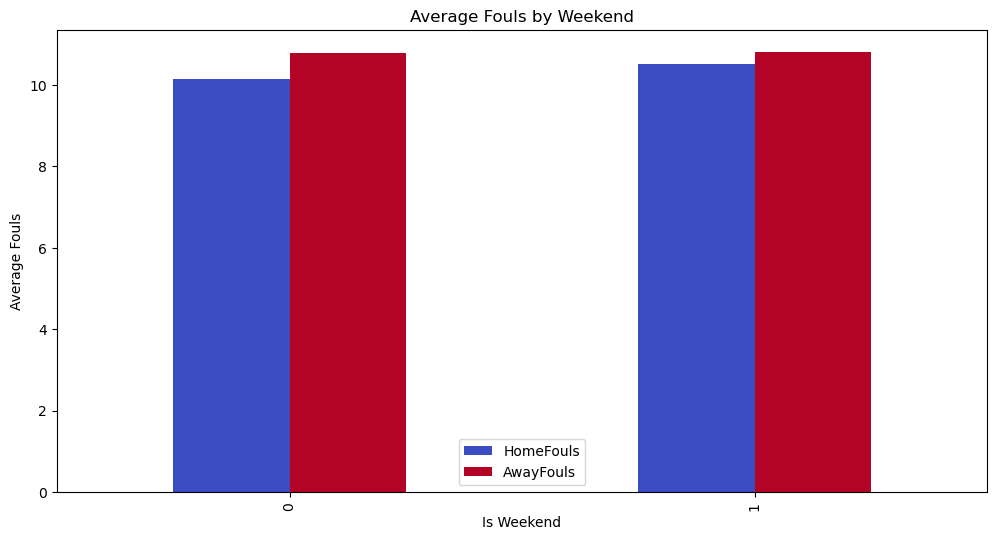

In [25]:
# plot the fouls by weekend
weekend_fouls = weekend_win.groupby('IsWeekend').mean(numeric_only =True).drop(columns=['HomeYellowCards', 'AwayYellowCards'])
weekend_fouls.plot(kind='bar', figsize=(12, 6), colormap='coolwarm')
plt.xlabel('Is Weekend')
plt.ylabel('Average Fouls')
plt.title('Average Fouls by Weekend')
plt.show()

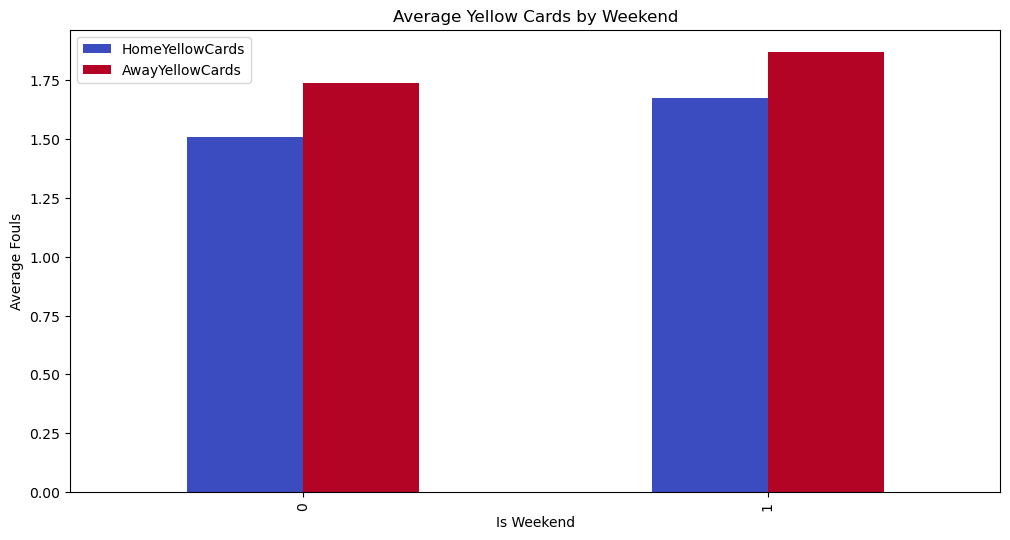

In [26]:
# plot the fouls by weekend
weekend_fouls = weekend_win.groupby('IsWeekend').mean(numeric_only =True).drop(columns=['HomeFouls', 'AwayFouls'])
weekend_fouls.plot(kind='bar', figsize=(12, 6), colormap='coolwarm')
plt.xlabel('Is Weekend')
plt.ylabel('Average Fouls')
plt.title('Average Yellow Cards by Weekend')
plt.show()

## checking the differences in corners ("HomeCorners"-"AwayCorners") vs. wins

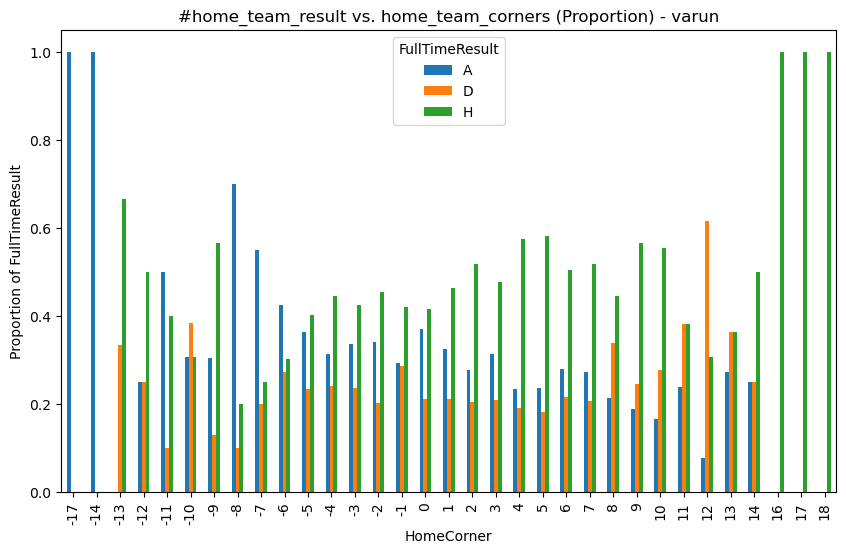

In [27]:
# Group by HomeCorner and count each FullTimeResult value
combined_df_test = combined_df.copy()
combined_df_test["FTCornerDifference"] = combined_df_test["HomeCorners"]-combined_df_test["AwayCorners"]

pivot = combined_df_test.groupby("FTCornerDifference")["FullTimeResult"].value_counts().unstack(fill_value=0)

# Convert counts to proportions by dividing each row by its sum
prop = pivot.div(pivot.sum(axis=1), axis=0)

# Optional: visualize the proportions with a stacked bar chart
prop.plot(kind="bar", stacked=False, figsize=(10, 6))
plt.title("#home_team_result vs. home_team_corners (Proportion) - varun")
plt.xlabel("HomeCorner")
plt.ylabel("Proportion of FullTimeResult")
plt.legend(title="FullTimeResult")
plt.show()


## checking the effect of "AwayRedCards" vs. wins

                     A         D         H
AwayRedCards                              
0             0.312815  0.224958  0.462227
1             0.225225  0.261261  0.513514
2             0.000000  0.000000  1.000000


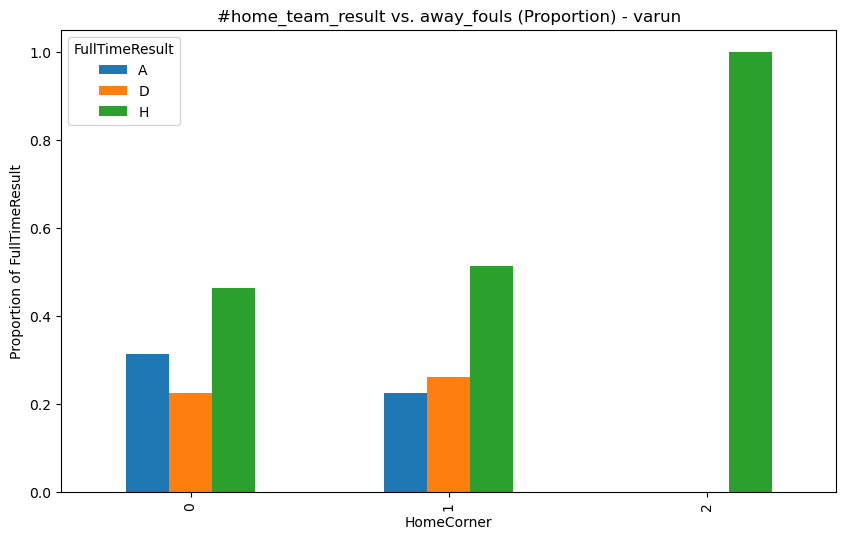

In [28]:
# Group by HomeCorner and count each FullTimeResult value
pivot = combined_df.groupby("AwayRedCards")["FullTimeResult"].value_counts().unstack(fill_value=0)

# Convert counts to proportions by dividing each row by its sum
prop = pivot.div(pivot.sum(axis=1), axis=0)

# Display the resulting proportions
print(prop)

# Optional: visualize the proportions with a stacked bar chart
prop.plot(kind="bar", stacked=False, figsize=(10, 6))
plt.title("#home_team_result vs. away_fouls (Proportion) - varun")
plt.xlabel("HomeCorner")
plt.ylabel("Proportion of FullTimeResult")
plt.legend(title="FullTimeResult")
plt.show()


## are referees themselves just biased?

                     A         D         H
Referee                                   
A Madley      0.333333  0.233333  0.433333
A Marriner    0.336957  0.239130  0.423913
A Taylor      0.283784  0.229730  0.486486
C Kavanagh    0.306122  0.214286  0.479592
C Pawson      0.398230  0.185841  0.415929
D Bond        0.333333  0.222222  0.444444
D Coote       0.276923  0.200000  0.523077
D England     0.225806  0.290323  0.483871
G Scott       0.253731  0.194030  0.552239
J Brooks      0.292683  0.268293  0.439024
J Gillett     0.447368  0.184211  0.368421
J Moss        0.345679  0.222222  0.432099
J Smith       0.000000  0.400000  0.600000
K Friend      0.232877  0.232877  0.534247
L Mason       0.264151  0.264151  0.471698
L Probert     0.312500  0.281250  0.406250
L Smith       0.500000  0.000000  0.500000
M Atkinson    0.370787  0.247191  0.382022
M Dean        0.271605  0.246914  0.481481
M Donohue     1.000000  0.000000  0.000000
M Jones       0.166667  0.250000  0.583333
M Oliver   

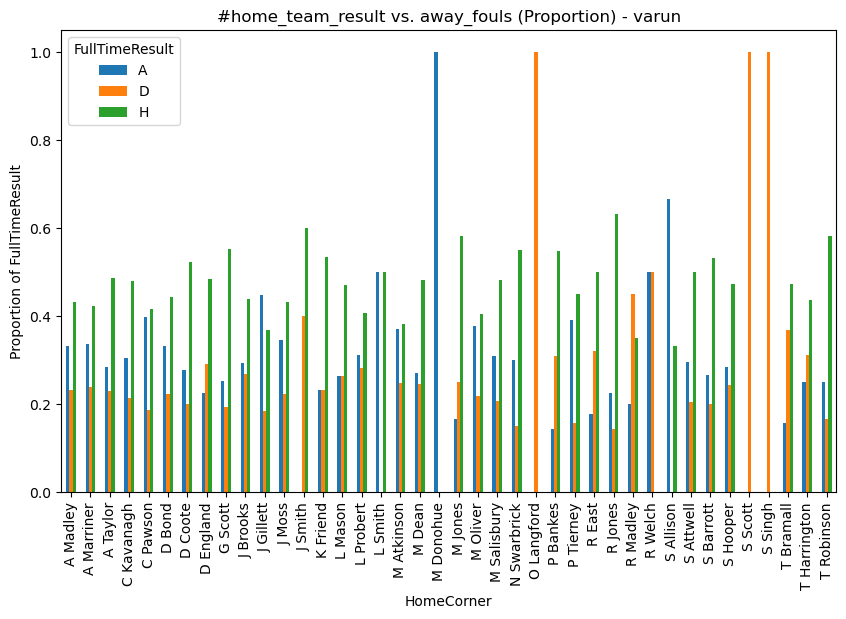

In [29]:
# Group by HomeCorner and count each FullTimeResult value
combined_df["Referee"] = combined_df["Referee"].apply(lambda x: x.strip())
pivot = combined_df.groupby("Referee")["FullTimeResult"].value_counts().unstack(fill_value=0)

# Convert counts to proportions by dividing each row by its sum
prop = pivot.div(pivot.sum(axis=1), axis=0)

# Display the resulting proportions
print(prop)

# Optional: visualize the proportions with a stacked bar chart
prop.plot(kind="bar", stacked=False, figsize=(10, 6))
plt.title("#home_team_result vs. away_fouls (Proportion) - varun")
plt.xlabel("HomeCorner")
plt.ylabel("Proportion of FullTimeResult")
plt.legend(title="FullTimeResult")
plt.show()


In [30]:
df = pd.get_dummies(combined_df, columns=['FullTimeResult', 'HalfTimeResult', 'Season', "Referee"], drop_first=False)
df = df.drop(columns={"MatchDate", 'KickoffTime','HomeTeam', 'AwayTeam'})

In [31]:
df_numerical["FTR"] = (combined_df["FullTimeResult"]=="H").astype(int)

df_numerical_difference = df_numerical.copy()

df_numerical_difference["FTShotsDifference"] = df_numerical_difference["HomeShotsOnTarget"]-df_numerical_difference["AwayShotsOnTarget"]
df_numerical_difference["FTCornerDifference"] = df_numerical_difference["HomeCorners"]-df_numerical_difference["AwayCorners"]
df_numerical_difference["FTFoulDifference"] = df_numerical_difference["HomeFouls"]-df_numerical_difference["AwayFouls"]

df_numerical.columns

Index(['FullTimeHomeGoals', 'FullTimeAwayGoals', 'HalfTimeHomeGoals',
       'HalfTimeAwayGoals', 'HomeShots', 'AwayShots', 'HomeShotsOnTarget',
       'AwayShotsOnTarget', 'HomeCorners', 'AwayCorners', 'HomeFouls',
       'AwayFouls', 'HomeYellowCards', 'AwayYellowCards', 'HomeRedCards',
       'AwayRedCards', 'FTR'],
      dtype='object')

Optimization terminated successfully.
         Current function value: 0.535001
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    FTR   No. Observations:                 1900
Model:                          Logit   Df Residuals:                     1891
Method:                           MLE   Df Model:                            8
Date:                Fri, 14 Mar 2025   Pseudo R-squ.:                  0.2255
Time:                        17:18:06   Log-Likelihood:                -1016.5
converged:                       True   LL-Null:                       -1312.5
Covariance Type:            nonrobust   LLR p-value:                1.194e-122
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.1848      0.235     -0.787      0.431      -0.645       0.275
HomeShot

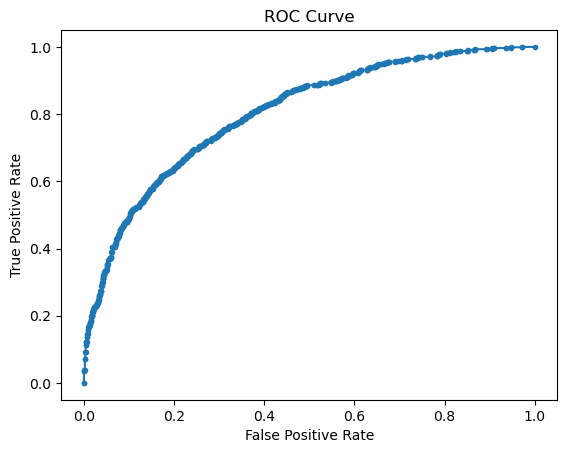

In [32]:
X = df_numerical.drop(columns=["FTR", "FullTimeHomeGoals", "HalfTimeHomeGoals", "FullTimeAwayGoals", "HalfTimeAwayGoals", "HomeShots", "AwayShots", "HomeFouls", "AwayFouls"])
y = df_numerical["FTR"]

# Add a constant term to the predictors
X_const = sm.add_constant(X)

# Fit the logistic regression model
logit_model = sm.Logit(y, X_const)
result = logit_model.fit()

# Print the logistic regression results
print(result.summary())

# Calculate predicted probabilities
y_prob = result.predict(X_const)

# Apply a 0.5 threshold to get binary predictions
y_pred = (y_prob >= 0.5).astype(int)

# Evaluate performance metrics
cm = confusion_matrix(y, y_pred)
acc = accuracy_score(y, y_pred)
prec = precision_score(y, y_pred)
rec = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
auc = roc_auc_score(y, y_prob)

print("\nConfusion Matrix:\n", cm)
print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1-score:  {f1:.3f}")
print(f"AUC:       {auc:.3f}")

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y, y_prob)
plt.plot(fpr, tpr, marker='.')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

         Current function value: 0.534815
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                    FTR   No. Observations:                 1900
Model:                          Logit   Df Residuals:                     1891
Method:                           MLE   Df Model:                            8
Date:                Fri, 14 Mar 2025   Pseudo R-squ.:                  0.2258
Time:                        17:18:06   Log-Likelihood:                -1016.1
converged:                      False   LL-Null:                       -1312.5
Covariance Type:            nonrobust   LLR p-value:                8.422e-123
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.3210      0.234     -1.371      0.170      -0.780       0.138
HomeFouls              0.0008   6.21e+05 

c:\Users\prita\miniforge3\envs\dsc80\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


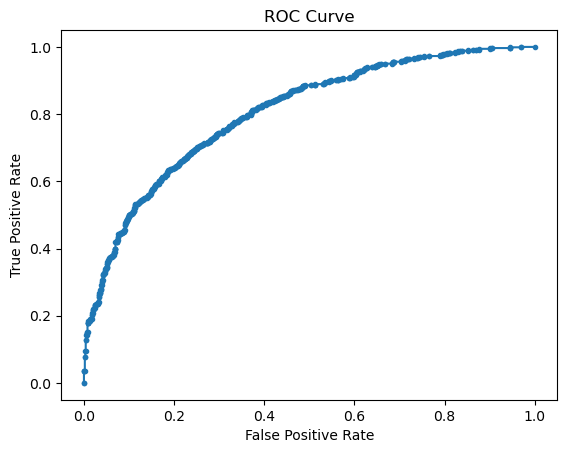

In [33]:
X = df_numerical_difference.drop(columns=["FTR", "FullTimeHomeGoals", "HalfTimeHomeGoals", "FullTimeAwayGoals", "HalfTimeAwayGoals", "HomeShots", "AwayShots", "HomeShotsOnTarget", "AwayShotsOnTarget", "HomeCorners", "AwayCorners"])
y = df_numerical_difference["FTR"]

# Add a constant term to the predictors
X_const = sm.add_constant(X)

# Fit the logistic regression model
logit_model = sm.Logit(y, X_const)
result = logit_model.fit()

# Print the logistic regression results
print(result.summary())

# Calculate predicted probabilities
y_prob = result.predict(X_const)

# Apply a 0.5 threshold to get binary predictions
y_pred = (y_prob >= 0.5).astype(int)

# Evaluate performance metrics
cm = confusion_matrix(y, y_pred)
acc = accuracy_score(y, y_pred)
prec = precision_score(y, y_pred)
rec = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
auc = roc_auc_score(y, y_prob)

print("\nConfusion Matrix:\n", cm)
print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1-score:  {f1:.3f}")
print(f"AUC:       {auc:.3f}")

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y, y_prob)
plt.plot(fpr, tpr, marker='.')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

                         VIF
FullTimeHomeGoals   8.808936
FullTimeAwayGoals   6.546275
HalfTimeHomeGoals   3.250945
HalfTimeAwayGoals   3.210024
HomeShots          16.651594
AwayShots          15.084608
HomeShotsOnTarget  11.938846
AwayShotsOnTarget  10.373473
HomeCorners         6.678771
AwayCorners         5.748688
HomeFouls          10.264663
AwayFouls           9.981981
HomeYellowCards     3.221852
AwayYellowCards     3.651268
HomeRedCards        1.097015
AwayRedCards        1.091861
FTR                 4.703131


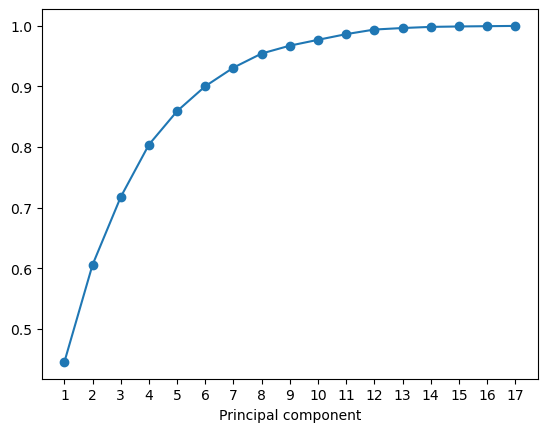

[0.44528275 0.60578598 0.71765151 0.804043   0.85936442 0.90049572
 0.93118724 0.95443833 0.96741939 0.9770748  0.98645014 0.99402343
 0.99654116 0.99840399 0.999103   0.99957918 1.        ]


NameError: name 'df_new' is not defined

In [34]:
import statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor # type: ignore

X_new = df_numerical.copy()
vif = pd.DataFrame([variance_inflation_factor(X_new.values, i) for i in range(X_new.shape[1])], index=X_new.columns, columns=['VIF'])
print(vif)

pca = PCA()
pca.fit(X_new)

Z = pca.transform(X_new)

# scree plot
plt.plot(range(1, X_new.shape[1] + 1), (pca.explained_variance_ratio_.cumsum()), marker='o')
plt.xticks(np.arange(1, X_new.shape[1] + 1, 1))
plt.xlabel('Principal component')
plt.show()

print(pca.explained_variance_ratio_.cumsum())

q = 9
factor_loadings = pd.DataFrame(-pca.components_[0:q,:].round(2), columns=X_new.columns)
factor_loadings

pca.transform(X_new)[:, 0:q]

pca_X = -pca.transform(X_new)[:,:q]

pca_df = pd.DataFrame(pca_X, columns=['Z1', 'Z2', 'Z3', 'Z4', 'Z5', 'Z6', 'Z7', 'Z8', 'Z9'])
pca_df["FTR"] = df_new["FullTimeResult"].reset_index(drop=True)

#include new variable = FTAwayG-FTHomeG
#run pca on only the numerical covariates

Z = pca_df.drop('FTR', axis=1)
vif = pd.DataFrame([variance_inflation_factor(Z.values, i) for i in range(Z.shape[1])], index=Z.columns, columns=['VIF'])
print(vif)

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import acf

pca_fit = smf.logit('FTR ~ Z1 + Z2 + Z3 + Z4 + Z5 + Z6 + Z7 + Z8 + Z9', pca_df).fit(cov_type="hc0")

print(pca_fit.summary())

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score
)

# 1. Get predicted probabilities (scores) from your logistic model
y_true = pca_df["FTR"]  # Ground truth
y_score = pca_fit.predict(pca_df)  # Predicted probabilities

# 2. Apply a 0.5 threshold to get class predictions
y_pred = (y_score >= 0.5).astype(int)

# 3. Evaluate metrics
cm = confusion_matrix(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_score)

print("Confusion Matrix:\n", cm)
print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1-score:  {f1:.3f}")
print(f"AUC:       {auc:.3f}")

# 4. Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_score)

import matplotlib.pyplot as plt

plt.plot(fpr, tpr, marker='.')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

In [ ]:
# advice - try other models ; maybe randomforest/svm (did he cover this though?) ; try 8 principal components; maybe 6
# try interaction terms? polynomial terms - polynomial reg instead of linear reg for the logit function

#interaction terms - fouls*redcards/yellowcards ; look at the accuracy/precision when looking at the interaction terms
#what more can you include in the model to improve the performance - maybe referees? maybe league? maybe before/after VAR?
#
#do multiple logistic regressions ; feature engineering to show depth

                         VIF
FullTimeHomeGoals   6.295562
FullTimeAwayGoals   5.484082
HalfTimeHomeGoals   3.245895
HalfTimeAwayGoals   3.204703
HomeShots          16.632693
AwayShots          15.057361
HomeShotsOnTarget  11.938798
AwayShotsOnTarget  10.373318
HomeCorners         6.670593
AwayCorners         5.718697
HomeFouls          10.230195
AwayFouls           9.884597
HomeYellowCards     3.220434
AwayYellowCards     3.650118
HomeRedCards        1.096852
AwayRedCards        1.091764


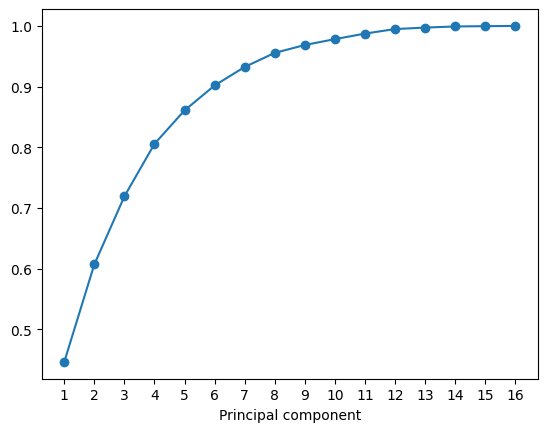

[0.44600165 0.60682252 0.71891425 0.80548142 0.8606374  0.90179329
 0.93227024 0.95552506 0.96851973 0.97819427 0.98732115 0.99481328
 0.99725699 0.99910076 0.9995779  1.        ]
    VIF
Z1  1.0
Z2  1.0
Z3  1.0
Z4  1.0
Z5  1.0
Z6  1.0
Z7  1.0
Z8  1.0
Z9  1.0
Optimization terminated successfully.
         Current function value: 0.414238
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    FTR   No. Observations:                 1900
Model:                          Logit   Df Residuals:                     1890
Method:                           MLE   Df Model:                            9
Date:                Fri, 14 Mar 2025   Pseudo R-squ.:                  0.4004
Time:                        15:48:17   Log-Likelihood:                -787.05
converged:                       True   LL-Null:                       -1312.5
Covariance Type:                  hc0   LLR p-value:                1.770e-220
      

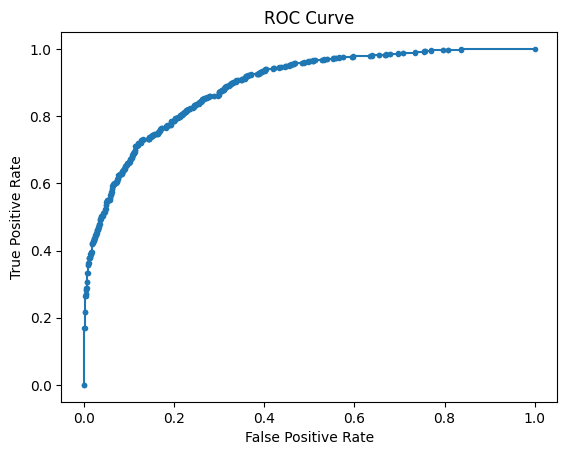

In [ ]:
import statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor # type: ignore

df_numerical_difference = combined_df.drop(columns={"MatchDate", 'KickoffTime','HomeTeam', 'AwayTeam', 'HalfTimeResult', 'Season', "Referee"})
df_numerical_difference["FullTimeResult"] = (df_new["FullTimeResult"] == "H").astype(int)

X_new = df_numerical_difference.drop(columns={"FullTimeResult"})
vif = pd.DataFrame([variance_inflation_factor(X_new.values, i) for i in range(X_new.shape[1])], index=X_new.columns, columns=['VIF'])
print(vif)

pca = PCA()
pca.fit(X_new)

Z = pca.transform(X_new)

# scree plot
plt.plot(range(1, X_new.shape[1] + 1), (pca.explained_variance_ratio_.cumsum()), marker='o')
plt.xticks(np.arange(1, X_new.shape[1] + 1, 1))
plt.xlabel('Principal component')
plt.show()

print(pca.explained_variance_ratio_.cumsum())

q = 9
factor_loadings = pd.DataFrame(-pca.components_[0:q,:].round(2), columns=X_new.columns)
factor_loadings

pca.transform(X_new)[:, 0:q]

pca_X = -pca.transform(X_new)[:,:q]

pca_df = pd.DataFrame(pca_X, columns=['Z1', 'Z2', 'Z3', 'Z4', 'Z5', 'Z6', 'Z7', 'Z8', 'Z9'])
pca_df["FTR"] = df_new["FullTimeResult"].reset_index(drop=True)

#include new variable = FTAwayG-FTHomeG
#run pca on only the numerical covariates

Z = pca_df.drop('FTR', axis=1)
vif = pd.DataFrame([variance_inflation_factor(Z.values, i) for i in range(Z.shape[1])], index=Z.columns, columns=['VIF'])
print(vif)

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import acf

pca_fit = smf.logit('FTR ~ Z1 + Z2 + Z3 + Z4 + Z5 + Z6 + Z7 + Z8 + Z9', pca_df).fit(cov_type="hc0")

print(pca_fit.summary())

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score
)

# 1. Get predicted probabilities (scores) from your logistic model
y_true = pca_df["FTR"]  # Ground truth
y_score = pca_fit.predict(pca_df)  # Predicted probabilities

# 2. Apply a 0.5 threshold to get class predictions
y_pred = (y_score >= 0.5).astype(int)

# 3. Evaluate metrics
cm = confusion_matrix(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_score)

print("Confusion Matrix:\n", cm)
print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1-score:  {f1:.3f}")
print(f"AUC:       {auc:.3f}")

# 4. Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_score)

import matplotlib.pyplot as plt

plt.plot(fpr, tpr, marker='.')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

# 4 PC's

                         VIF
FullTimeHomeGoals   6.295562
FullTimeAwayGoals   5.484082
HalfTimeHomeGoals   3.245895
HalfTimeAwayGoals   3.204703
HomeShots          16.632693
AwayShots          15.057361
HomeShotsOnTarget  11.938798
AwayShotsOnTarget  10.373318
HomeCorners         6.670593
AwayCorners         5.718697
HomeFouls          10.230195
AwayFouls           9.884597
HomeYellowCards     3.220434
AwayYellowCards     3.650118
HomeRedCards        1.096852
AwayRedCards        1.091764


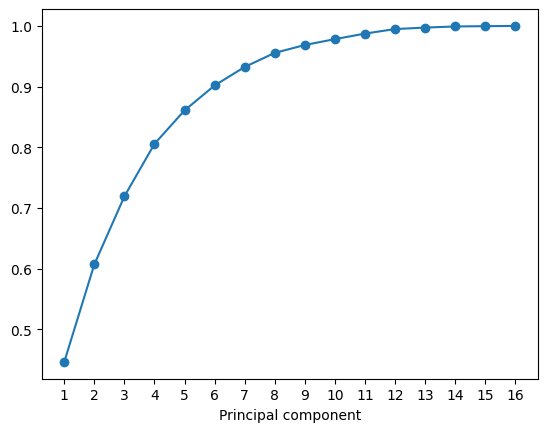

[0.44600165 0.60682252 0.71891425 0.80548142 0.8606374  0.90179329
 0.93227024 0.95552506 0.96851973 0.97819427 0.98732115 0.99481328
 0.99725699 0.99910076 0.9995779  1.        ]
    VIF
Z1  1.0
Z2  1.0
Z3  1.0
Z4  1.0
Optimization terminated successfully.
         Current function value: 0.638909
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                    FTR   No. Observations:                 1900
Model:                          Logit   Df Residuals:                     1895
Method:                           MLE   Df Model:                            4
Date:                Fri, 14 Mar 2025   Pseudo R-squ.:                 0.07512
Time:                        15:50:13   Log-Likelihood:                -1213.9
converged:                       True   LL-Null:                       -1312.5
Covariance Type:                  hc0   LLR p-value:                 1.499e-41
                 coef    std err          z   

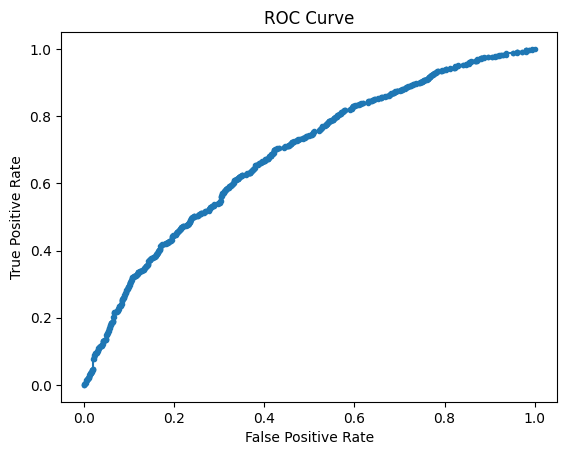

In [ ]:
import statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor # type: ignore

X_new = df_numerical.drop(columns={"FTR"})
vif = pd.DataFrame([variance_inflation_factor(X_new.values, i) for i in range(X_new.shape[1])], index=X_new.columns, columns=['VIF'])
print(vif)

pca = PCA()
pca.fit(X_new)

Z = pca.transform(X_new)

# scree plot
plt.plot(range(1, X_new.shape[1] + 1), (pca.explained_variance_ratio_.cumsum()), marker='o')
plt.xticks(np.arange(1, X_new.shape[1] + 1, 1))
plt.xlabel('Principal component')
plt.show()

print(pca.explained_variance_ratio_.cumsum())

q = 4
factor_loadings = pd.DataFrame(-pca.components_[0:q,:].round(2), columns=X_new.columns)
factor_loadings

pca.transform(X_new)[:, 0:q]

pca_X = -pca.transform(X_new)[:,:q]

pca_df = pd.DataFrame(pca_X, columns=['Z1', 'Z2', 'Z3', 'Z4'])
pca_df["FTR"] = df_numerical["FTR"].reset_index(drop=True)

#include new variable = FTAwayG-FTHomeG
#run pca on only the numerical covariates

Z = pca_df.drop('FTR', axis=1)
vif = pd.DataFrame([variance_inflation_factor(Z.values, i) for i in range(Z.shape[1])], index=Z.columns, columns=['VIF'])
print(vif)

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import acf

pca_fit = smf.logit('FTR ~ Z1 + Z2 + Z3 + Z4', pca_df).fit(cov_type="hc0")

print(pca_fit.summary())

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score
)

# 1. Get predicted probabilities (scores) from your logistic model
y_true = pca_df["FTR"]  # Ground truth
y_score = pca_fit.predict(pca_df)  # Predicted probabilities

# 2. Apply a 0.5 threshold to get class predictions
y_pred = (y_score >= 0.5).astype(int)

# 3. Evaluate metrics
cm = confusion_matrix(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_score)

print("Confusion Matrix:\n", cm)
print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1-score:  {f1:.3f}")
print(f"AUC:       {auc:.3f}")

# 4. Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_score)

import matplotlib.pyplot as plt

plt.plot(fpr, tpr, marker='.')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

In [ ]:
df_new.columns

Index(['FullTimeHomeGoals', 'FullTimeAwayGoals', 'FullTimeResult',
       'HalfTimeHomeGoals', 'HalfTimeAwayGoals', 'HomeShots', 'AwayShots',
       'HomeShotsOnTarget', 'AwayShotsOnTarget', 'HomeCorners', 'AwayCorners',
       'HomeFouls', 'AwayFouls', 'HomeYellowCards', 'AwayYellowCards',
       'HomeRedCards', 'AwayRedCards'],
      dtype='object')

In [ ]:
df_numerical.columns

Index(['FullTimeHomeGoals', 'FullTimeAwayGoals', 'HalfTimeHomeGoals',
       'HalfTimeAwayGoals', 'HomeShots', 'AwayShots', 'HomeShotsOnTarget',
       'AwayShotsOnTarget', 'HomeCorners', 'AwayCorners', 'HomeFouls',
       'AwayFouls', 'HomeYellowCards', 'AwayYellowCards', 'HomeRedCards',
       'AwayRedCards', 'FTR'],
      dtype='object')

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt

# ----------------------------
# Prepare the Data
# ----------------------------
# Assume your DataFrame is named df and includes:
# "HomeFouls", "AwayFouls", "FullTimeResult" with values "H", "D", "A"

# For checking linearity in the logit, we convert the outcome to binary.
# Here we create a binary variable for Home wins (Outcome_H: 1 if "H", 0 otherwise)

# ----------------------------
# 1. Linearity in the Logit (Box-Tidwell Test)
# ----------------------------
# For each continuous predictor, we create an interaction with its natural log.
# (Add a small constant to avoid log(0) if needed.)
df_new['HomeFouls_log'] = df_new['HomeFouls'] * np.log(df_new['HomeFouls'] + 1e-5)
df_new['AwayFouls_log'] = df_new['AwayFouls'] * np.log(df_new['AwayFouls'] + 1e-5)

# Fit a logistic regression model including these interaction terms.
model = smf.logit("FullTimeResult ~ HomeFouls_log + AwayFouls_log", data=df_new).fit()
print(model.summary())

# Interpretation:
# - If the coefficients for HomeFouls_log or AwayFouls_log are statistically significant (p < 0.05),
#   then the assumption of linearity in the logit may be violated for that predictor.
#
# ----------------------------
# 2. Multicollinearity Check (Variance Inflation Factor - VIF)
# ----------------------------
# We check if HomeFouls and AwayFouls are highly correlated.
X = df_new[['HomeFouls', 'AwayFouls']]
X = sm.add_constant(X)  # Adds an intercept term
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\nVariance Inflation Factor (VIF):")
print(vif_data)

# Interpretation:
# - VIF values above 5 (or sometimes 10) indicate a potential multicollinearity problem.

# ----------------------------
# 3. Influential Observations (Cook's Distance)
# ----------------------------
influence = model.get_influence()
cooks, _ = influence.cooks_distance

plt.figure(figsize=(10, 4))
plt.stem(np.arange(len(cooks)), cooks, markerfmt=",")
plt.title("Cook's Distance for Observations")
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.show()

# Interpretation:
# - Observations with a Cook's distance substantially larger than the others may be overly influential.

# ----------------------------
# Additional Considerations:
# ----------------------------
# - Independence: Ensure your data collection method provides independent observations.
# - Perfect Separation: If any predictor perfectly predicts Outcome_H, the model may not converge.
# - Sample Size: Logistic regression (via maximum likelihood) typically requires a reasonable sample size.
# - For Multinomial Logistic Regression: Check the IIA assumption if applicable.

# This code provides diagnostics to help you verify some of the conditions 
# necessary for logistic regression.


#### Some Non-Parametric Tests

In [ ]:
# Two sample KS test for HomeCorners and AwayCorners
# Null Hypothesis: The distributions of home and away corners are the same
# Alternative Hypothesis: The distributions of home and away corners are different

ks_stat, p_value = ks_2samp(combined_df['HomeCorners'], combined_df['AwayCorners'])
print(f'Two-sample KS Test Statistic: {ks_stat}, p-value: {p_value}')

significance_level = 0.05
if p_value < significance_level:
    print('Reject the null hypothesis: The distributions of home and away corners are different')
else:
    print('Fail to reject the null hypothesis: The distributions of home and away corners are similar')


Two-sample KS Test Statistic: 0.15526315789473685, p-value: 2.1028493913534586e-12
Reject the null hypothesis: The distributions of home and away corners are different


In [ ]:
# Two sample KS test for HomeFouls and AwayFouls
# Null Hypothesis: The distributions of home and away fouls are the same
# Alternative Hypothesis: The distributions of home and away fouls are different

ks_stat, p_value = ks_2samp(combined_df['HomeFouls'], combined_df['AwayFouls'])
print(f'Two-sample KS Test Statistic: {ks_stat}, p-value: {p_value}')

significance_level = 0.05
if p_value < significance_level:
    print('Reject the null hypothesis: The distributions of home and away fouls are different')
else:
    print('Fail to reject the null hypothesis: The distributions of home and away fouls are similar')

Two-sample KS Test Statistic: 0.04736842105263158, p-value: 0.15488969421401397
Fail to reject the null hypothesis: The distributions of home and away fouls are similar


In [ ]:
# Two sample KS test for HomeYellowCards and AwayYellowCards
# Null Hypothesis: The distributions of home and away yellow cards are the same
# Alternative Hypothesis: The distributions of home and away yellow cards are different

ks_stat, p_value = ks_2samp(combined_df['HomeYellowCards'], combined_df['AwayYellowCards'])
print(f'Two-sample KS Test Statistic: {ks_stat}, p-value: {p_value}')

significance_level = 0.05
if p_value < significance_level:
    print('Reject the null hypothesis: The distributions of home and away yellow cards are different')
else:
    print('Fail to reject the null hypothesis: The distributions of home and away yellow cards are similar')

Two-sample KS Test Statistic: 0.07631578947368421, p-value: 0.0026061879353490923
Reject the null hypothesis: The distributions of home and away yellow cards are different


In [ ]:
# Two sample KS test for HomeRedCards and AwayRedCards
# Null Hypothesis: The distributions of home and away red cards are the same
# Alternative Hypothesis: The distributions of home and away red cards are different

ks_stat, p_value = ks_2samp(combined_df['HomeRedCards'], combined_df['AwayRedCards'])
print(f'Two-sample KS Test Statistic: {ks_stat}, p-value: {p_value}')

significance_level = 0.05
if p_value < significance_level:
    print('Reject the null hypothesis: The distributions of home and away red cards are different')
else:
    print('Fail to reject the null hypothesis: The distributions of home and away red cards are similar')

Two-sample KS Test Statistic: 0.014912280701754385, p-value: 0.9995882449402531
Fail to reject the null hypothesis: The distributions of home and away red cards are similar


#### SVM Classifier

Train Accuracy: 0.738
Test Accuracy: 0.716


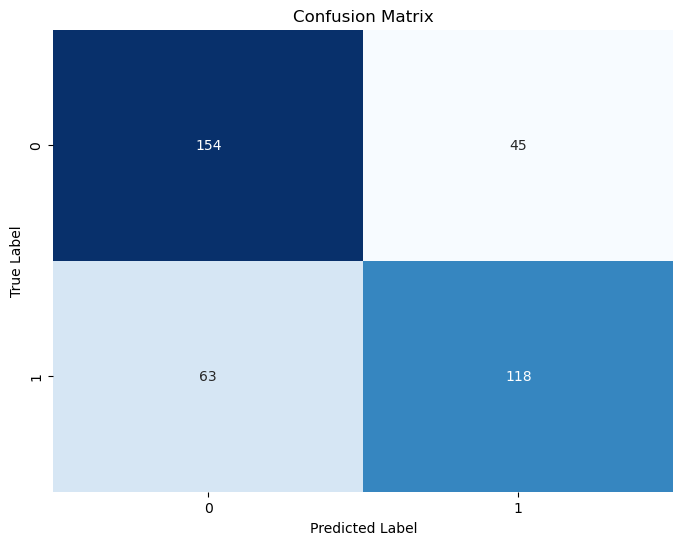

In [40]:
# train a SVM classifier on the data
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Prepare the data
X = df_numerical_difference.drop(columns=["FTR", "FullTimeHomeGoals", "HalfTimeHomeGoals", "FullTimeAwayGoals", "HalfTimeAwayGoals", "HomeShots", "AwayShots", "HomeFouls", "AwayFouls"])
y = df_numerical_difference["FTR"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the SVM classifier
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

# Make predictions
y_pred_train = svm.predict(X_train)
y_pred_test = svm.predict(X_test)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Train Accuracy: {train_accuracy:.3f}")
print(f"Test Accuracy: {test_accuracy:.3f}")

# create a confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



Difference in features

Train Accuracy: 0.728
Test Accuracy: 0.718


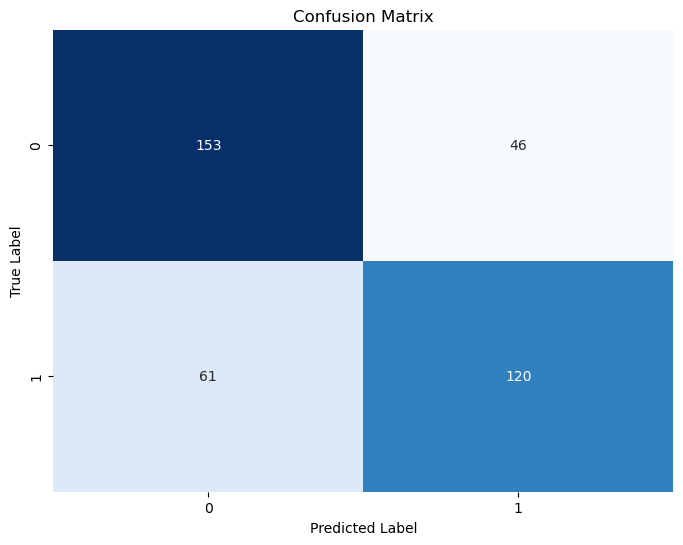

In [41]:
# create another SVM classifier

# Prepare the data
X = df_numerical_difference.drop(columns=["FTR", "FullTimeHomeGoals", "HalfTimeHomeGoals", "FullTimeAwayGoals", "HalfTimeAwayGoals", "HomeShots", "AwayShots", "HomeShotsOnTarget", "AwayShotsOnTarget", "HomeCorners", "AwayCorners"])
y = df_numerical_difference["FTR"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the SVM classifier
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

# Make predictions
y_pred_train = svm.predict(X_train)
y_pred_test = svm.predict(X_test)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Train Accuracy: {train_accuracy:.3f}")
print(f"Test Accuracy: {test_accuracy:.3f}")

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

9 PC

Train Accuracy: 0.816
Test Accuracy: 0.797


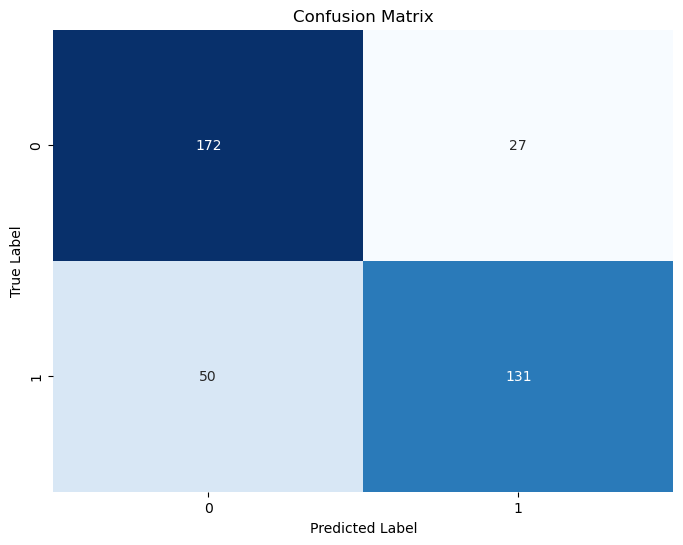

In [46]:
# create a new SVM classifier with the PCA features

# Prepare the data
X = pca_df
y = df_numerical_difference["FTR"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the SVM classifier
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

# Make predictions
y_pred_train = svm.predict(X_train)
y_pred_test = svm.predict(X_test)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Train Accuracy: {train_accuracy:.3f}")
print(f"Test Accuracy: {test_accuracy:.3f}")

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

6 PC

Train Accuracy: 0.736
Test Accuracy: 0.713


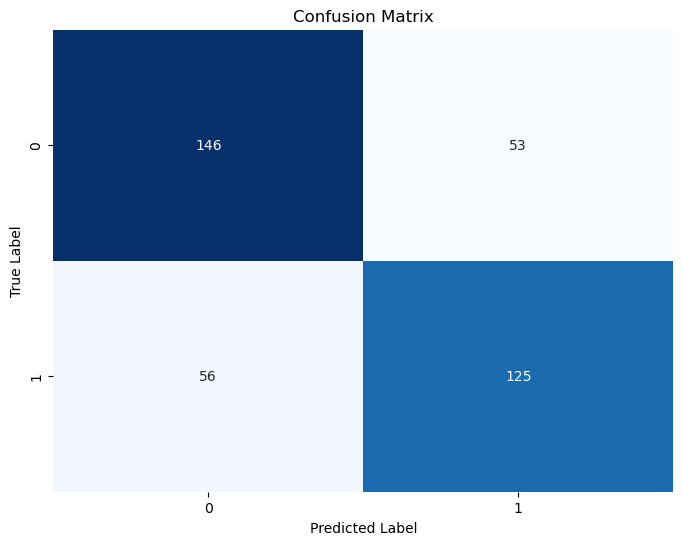

In [47]:
# repeat the PCA with 6 components

# Prepare the data
X = pca_df[['Z1', 'Z2', 'Z3', 'Z4', 'Z5', 'Z6']]
y = df_numerical_difference["FTR"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the SVM classifier
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

# Make predictions
y_pred_train = svm.predict(X_train)
y_pred_test = svm.predict(X_test)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Train Accuracy: {train_accuracy:.3f}")
print(f"Test Accuracy: {test_accuracy:.3f}")

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()